In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib import patches
import pandas as pd

from astropy import table
from astropy.io import fits
from astropy import units as u
from astropy import coordinates, cosmology
from astropy import wcs

from astroquery.mast import Catalogs
from astroquery.skyview import SkyView
from astroquery.simbad import Simbad
from astroquery.ipac.ned import Ned
Simbad.add_votable_fields('z_value')

from ekfobs import planning
from ekfobs import observe as eo
from ekfphys import observer, calibrations
from ekfplot import plot as ek
from ekfstats import sampling
from ekfparse import query

from agrias import utils
from skipper import observe

import sys
sys.path.append('../scripts')
import reader

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [3]:
def fha_from_sfr ( sample, z=0.08):
    dlum = cosmo.luminosity_distance(z).to(u.cm).value
    return calibrations.SFR2LHa(10.**sample['logsfr']) / (4*np.pi*dlum**2)
    

In [4]:
merian = table.Table(fits.getdata("/Users/kadofong/Downloads/Merian_DR1_photoz_EAZY_v2.0.fits", 1))#.to_pandas ()
ms = reader.merianselect ( merian, maglim=25.,)

/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:31: RuntimeWarning: invalid value encountered in log10
  n708mag = -2.5*np.log10(mertab[bu.photcols['N708']]) + zp


[merianselect] Only choosing sources at 0.060<z_phot<0.100
[merianselect] Only choosing sources with m_i < 25.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
lha_cat = calibrations.SFR2LHa( 10.**(ms['logssfr']+ ms['logmass']))
fha_cat = lha_cat / (4.*np.pi * cosmo.luminosity_distance(ms['z500'].values).to(u.cm).value**2)

In [6]:
palomar = observe.ObservingSite('palomar')
lco = observe.ObservingSite('CTIO')

# EELG Selection

In [7]:
sample_name = 'highmass_EELGs_LCO'
if not os.path.exists(sample_name):
    os.mkdir(sample_name)

for dirname in  ['thumbnails','cutouts','finding_charts']:
    dpath = f'{sample_name}/{dirname}'
    if not os.path.exists(dpath):
        os.mkdir(dpath)

Text(0, 0.5, '$\\log_{10}({\\rm SFR}/[\\rm M_\\odot\\ {\\rm yr}^{-1}])$')

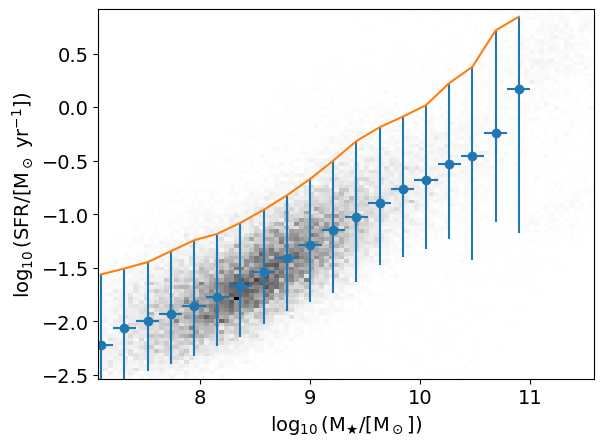

In [8]:
_=ek.hist2d(ms['logmass'], ms['logsfr'], bins=100)
midpts,qts=ek.running_quantile(
    ms['logmass'],
    ms['logsfr'],
    bins=np.linspace(7.,11,20),
    alpha=0.05
)
plt.plot(midpts, qts[:,2])
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.common_labels['logsfr'])

In [9]:
sfs_up10 = np.interp(ms['logmass'], midpts, qts[:,2])
is_abovesfs = ms['logsfr'] > sfs_up10

In [22]:
mi = utils.flux2mag(ms['i_cModelFlux_Merian'])
is_sb = is_abovesfs&(ms['logmass']>9)&(mi<20.5)
parent = ms.loc[is_sb]

In [24]:
matches = Simbad.query_region( coordinates.SkyCoord(parent.RA.values, parent.DEC.values, unit='deg'), radius=4.*u.arcsec)

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '2:19:25.44700672 -6:02:53.83296592': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 48 raised an error (recorded in the `errors` attribute of the result table): '2:37:37.14281198 -3:42:29.34798797': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 53 raised an error (recorded in the `errors` attribute of the result table): '2:39:29.82668794 -3:22:14.84107307': No astronomical objec

In [25]:
zlit_matches = parent.index[matches['SCRIPT_NUMBER_ID']-1]
parent.loc[zlit_matches,'z_lit'] = matches['Z_VALUE']
no_zlit = np.isnan(parent['z_lit'].values)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/732007537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent.loc[zlit_matches,'z_lit'] = matches['Z_VALUE']


In [30]:
year = 2024
month = 8
day = 31



coords = coordinates.SkyCoord(*parent[['RA','DEC']].values.T, unit='deg')

night_start, night_end = lco.get_sunriseset ( year, month, day )

obsframe = lco.define_obsframe ( obs_start=night_start, obs_end=night_end )
alt_l = [ lco.get_altitude(cc, obsframe) for cc in coords ]

is_observable = np.array([ np.nanmin(np.where(x.secz<0, 10.,x.secz)).value<1.4 for x in alt_l ])
sample = parent.loc[is_observable&no_zlit]
sample_callnames = ['MagE%s' % str(idx).zfill(3) for idx in range(len(sample))]

[observe] Computing sunrise and sunset on 2024/8/29 at altitude = -14.0


In [47]:
sample.to_csv(f'{sample_name}/targets.csv')
ostars.set_index(sample.index).to_csv(f'{sample_name}/offset_stars.csv')

In [36]:
ostars = planning.find_blindoffset_stars(coords[is_observable&no_zlit])

INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


65

In [39]:
paltargets = eo.PalomarTargetList (coords[is_observable&no_zlit], sample_callnames, )

In [40]:
palplan = paltargets.make_target_list(
    obsdates='%s-%s-%s' % (year, str(month).zfill(2), str(day).zfill(2)),
    slit_width=1.5*u.arcsec,
    offset_stars=coordinates.SkyCoord(ostars['ra'], ostars['dec'], unit='deg'),
    savename=f'{sample_name}/palomar_targets'
)

## Make Finding Charts

## Download Stamps

In [41]:
for idx in range(len(sample)):
    target = sample.iloc[idx]
    query.get_legacysurveyimage(
        target['RA'], target['DEC'], 
        savedir=f'./{sample_name}/thumbnails/', savename=sample.index[idx], pixscale=0.26, width=200, height=200, format='jpg'
    )


Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=34.85602919466116&dec=-6.048286934978619&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs_LCO/thumbnails/M2950675792578779008.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=37.86692620274253&dec=-6.494652861172411&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs_LCO/thumbnails/M2951309111276347805.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=35.103016877974916&dec=-5.6482679247975325&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs_LCO/thumbnails/M3036714776475487786.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=36.399071488610545&dec=-4.628497975106797&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs_LCO/thumbnails/M3036881902242915835.jpg
Saving:
https://www.legacysurvey.org/viewer/cutout.jpg?ra=39.40476171658294&dec=-3.708152218881903&layer=ls-dr9&pixscale=0.26&width=200&height=200
to ./highmass_EELGs_LC

In [42]:
for idx in range(len(sample)):
    ostar = ostars.iloc[idx]
    query.get_legacysurveyimage(ostar['ra'], ostar['dec'], savedir=f'./{sample_name}/cutouts/', 
                                savename=sample.index[idx], pixscale=1., width=300, height=300, verbose=False)

## Make Figures

In [43]:
for ridx in range(len(sample)):
    ostar = ostars.iloc[ridx]
    name = sample.index[ridx]
    cutout = fits.open(f'./{sample_name}/cutouts/{name}.fits')[0]
    cutout_wcs = wcs.WCS(cutout.header)
    
    row = sample.iloc[ridx]
    name = row.name
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_subplot(1,3,1)
    
    alt_l_index = np.arange(len(alt_l), dtype=int)[is_observable][ridx]
    ax.plot(obsframe.obstime.datetime, alt_l[alt_l_index].alt, 'o')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    #ax.set_xtic(rotation=45)
    tw = ax.twinx()
    tw.plot(obsframe.obstime.datetime, alt_l[alt_l_index].secz, 'o', color='C1')
    tw.set_ylim(1.,3.)
    tw.set_ylabel('airmass', color='C1', rotation=270, labelpad=20)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Time [UTC]')
    ax.set_ylabel('altitude', color='C0')
    
    
    ek.text(
        0.025,
        0.975,
        r'''%s
(%s)''' % (sample_callnames[ridx], row.name),
        ax=ax,
        fontsize=10,
        bordercolor='w',
        borderwidth=2
    )
    
    ax.spines.left.set_color("C0")

    
    ax=fig.add_axes(132, projection=cutout_wcs.celestial)
    ek.imshow(cutout.data[0],origin='lower', cmap='Greys', q=0.0025, ax=ax)
    
    msize = 20
    ek.celestial_plot(sample.iloc[ridx]['RA'], sample.iloc[ridx]['DEC'], ax, marker='o', markeredgecolor='lime', markerfacecolor='None', markersize=msize)
    ek.celestial_plot(ostar['ra'], ostar['dec'], ax, marker='o', markeredgecolor='cyan', markerfacecolor='None', markersize=msize)
    
    ek.text(0.025, 0.975, 'Offset Star', color='cyan', ax=ax, bordercolor='w', borderwidth=3)
    ek.text(0.025, 0.905, 'Science Target', color='lime', ax=ax, bordercolor='w', borderwidth=3)


    ras = [sample.iloc[ridx]['RA'], ostar['ra']]
    decs = [sample.iloc[ridx]['DEC'],ostar['dec']]
    ek.celestial_plot( ras, decs, ax, color='r', lw=0.2, ls=':' )
    ek.text(
        np.mean(ras),
        np.mean(decs),
        r"%i''" % ostar.distance_arcsec,
        color='tab:red',
        coord_type='absolute',
        bordercolor='w',
        borderwidth=2,
        transform=ax.get_transform('fk5'),
        ax=ax,
        fontsize=10
    )
        
    
    ax.grid(color='white', ls=':')
    ax.set_xlabel('RA [J2000]')
    ax.set_ylabel('DEC [J2000]')
    

    imax = fig.add_axes(133)
    thumbnail = mpimg.imread(f'./{sample_name}/thumbnails/{name}.jpg')
    imax.imshow(thumbnail)
    imax.axis('off')
    fha = fha_from_sfr(row)
    fha_oom = np.floor(np.log10(fha))

    ek.text(
        0.025,
        0.975,
        r'''$m_r = %.1f$
$m_{N708}=%.1f$
$F_{\rm H\alpha}^{\rm est} = %.2f\times 10^{%i} \frac{\rm erg}{\rm s\ cm^{2}}$'''%(
            utils.flux2mag(row['r_cModelFlux_Merian']),
            utils.flux2mag(row['N708_cModelFlux_Merian']),
            fha / 10.**fha_oom,
            fha_oom
        ),
        ax=imax,
        color='w',
        fontsize=12
    )
    plt.tight_layout ()
    
    pos = imax.get_position ()
    new_pos = [pos.x0 - 0.1, pos.y0, pos.width, pos.height]
    imax.set_position (new_pos)

    plt.savefig(f'./{sample_name}/finding_charts/{name}.png')
    plt.close()

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_473/3751278515.py:23: UserWarning: FixedFormatter should only be used together with FixedLoca